# Database exploration: forum, textbook and quiz events

In [1]:
#Library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime, timedelta, date
import time
import sys
import os

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [10]:
%load_ext autoreload
%autoreload 2

In [14]:
from helpers.db_connector import MySQLConnector
from helpers.data_process import *
from helpers.plotting import *
from helpers.db_query import *


In [145]:
%time video_events = getVideoEvents(with_2019=True)

CPU times: user 14.6 s, sys: 1.08 s, total: 15.7 s
Wall time: 18.3 s


## Textbook Events

In [65]:
%time textbook_events = getTextbookEvents()

CPU times: user 11.3 ms, sys: 2.48 ms, total: 13.8 ms
Wall time: 41.9 ms


In [66]:
textbook_events.sample(5)

,AccountUserID,DataPackageID,TimeStamp,EventType,Year,Date
168,96550,EPFL-AlgebreLineaire-2019,1577890690,TextBook.Seek,2019,2020-01-01 15:58:10
173,96550,EPFL-AlgebreLineaire-2019,1577891981,TextBook.Bookmark.Accessed,2019,2020-01-01 16:19:41
90,96550,EPFL-AlgebreLineaire-2019,1577962927,TextBook.Bookmark.Accessed,2019,2020-01-02 12:02:07
102,14648,EPFL-AlgebreLineaire-2018,1540670362,TextBook.Seek,2018,2018-10-27 21:59:22
35,10235,EPFL-AlgebreLineaire-2017_T3,1508064111,TextBook.Seek,2017,2017-10-15 12:41:51


In [45]:
print("Total number of events: ",len(textbook_events))
textbook_events.groupby("Year").size().to_frame(name="Number of events")

Total number of events:  317


,Number of events
Year,
2017,32
2018,159
2019,126


In [150]:
print("Total number of unique users: ",textbook_events.AccountUserID.nunique())
print("Proportion of users watching the videos: {:.2f}".format(textbook_events.AccountUserID.nunique() / video_events.AccountUserID.nunique()))
textbook_events.groupby("Year").AccountUserID.nunique().to_frame(name="Number of users")

Total number of unique users:  60
Proportion of users watching the videos: 0.12


,Number of users
Year,
2017,25
2018,20
2019,16


In [130]:
print("Two different events: {}".format(", ".join(textbook_events.EventType.unique())))
textbook_events.groupby("EventType").size().to_frame(name="Number of events")

Two different events: TextBook.Seek, TextBook.Bookmark.Accessed


,Number of events
EventType,
TextBook.Bookmark.Accessed,168
TextBook.Seek,149


In [229]:
def plot_events(df, ax, year=None):
    if year:
        #Count the number of events by day
        data = df.groupby(df.Date.dt.floor('d')).size() 
        sns.lineplot(data=data, ax=ax)
        ax.set_title("Events during {}".format(year))
        ax.set_xlim(datetime(year,9,1), datetime(year + 1,1,10)) #Filter the right period
        
        with open('../config/cf_mooc.json') as f:
            config = json.load(f)
        midterm = datetime.strptime(config[str(year)]["Midterm"], '%Y-%m-%d')
        ax.axvline(midterm, c='lightcoral', label="Midterm")
        ax.legend()

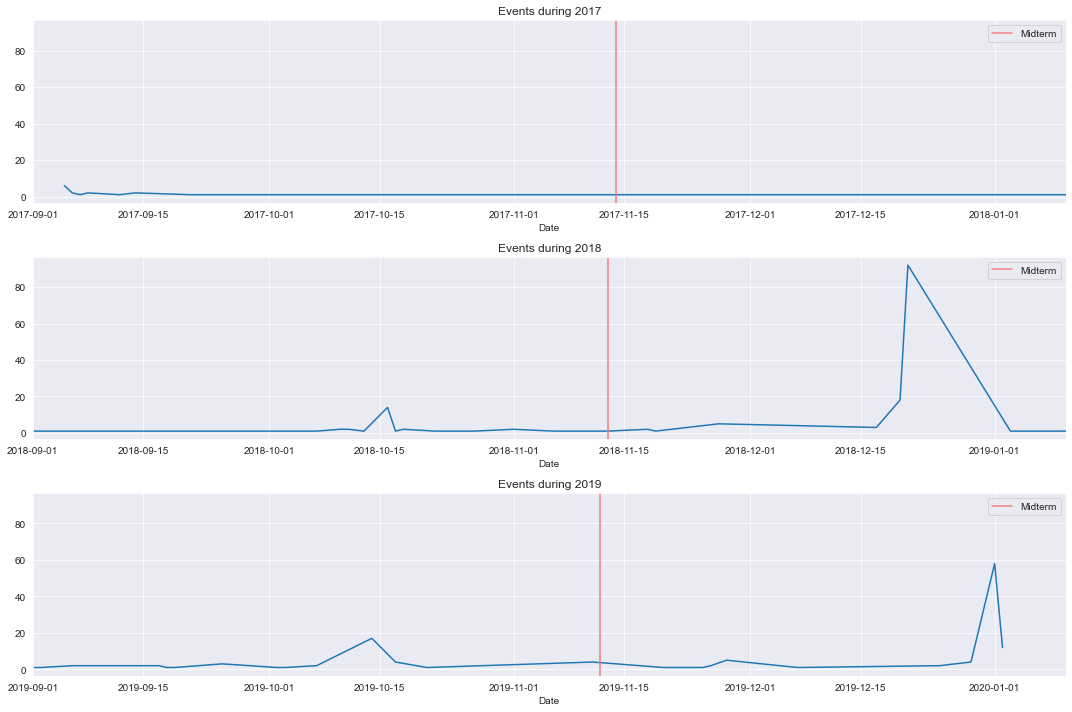

In [230]:
fig, axes = plt.subplots(3,1, figsize=((15,10)))
for i, year in enumerate([2017,2018,2019]):
    plot_events(textbook_events, axes[i], year = year)
fig.tight_layout()

**Interpretation:** We cannot see effect of the midterm on the textbook activity. However the trend increases at the end of the semester for 2018 and 2019. We can guess that students start going back on the course material and therefore start making use of the bookmarks.

## Forum Activity

In [180]:
%time forum_events = getForumEvents()

CPU times: user 36.7 ms, sys: 4.85 ms, total: 41.5 ms
Wall time: 55.7 ms


In [182]:
forum_events.sample(5)

,AccountUserID,DataPackageID,TimeStamp,EventType,PostType,PostID,Year,Date
1570,95011,EPFL-AlgebreLineaire-2019,1575966907,Forum.Unknown,Forum,None,2019,2019-12-10 09:35:07
1405,96844,EPFL-AlgebreLineaire-2019,1570360560,Forum.Load,Forum,None,2019,2019-10-06 13:16:00
273,12272,EPFL-AlgebreLineaire-2017_T3,1510564079,Forum.Thread.View,Thread,5a03695361678c47d0000000,2017,2017-11-13 10:07:59
5,4708,EPFL-AlgebreLineaire-2017_T3,1508400354,Forum.Load,Forum,None,2017,2017-10-19 10:05:54
701,8085,EPFL-AlgebreLineaire-2017_T3,1508404206,Forum.Load,Forum,None,2017,2017-10-19 11:10:06


In [183]:
print("Different forum events: \n\t{}".format("\n\t".join(forum_events.EventType.unique())))

Different forum events: 
	Forum.Load
	Forum.Thread.View
	Forum.Unknown
	Forum.Thread.Launch
	Forum.Post.Delete
	Forum.Thread.Delete
	Forum.Thread.PostOn
	Forum.User.View
	Forum.Thread.Upvote
	Forum.Post.Update
	Forum.Search
	Forum.Thread.Update
	Forum.Thread.Unfollow
	Forum.Thread.Follow


In [235]:
forum_events.groupby("EventType").size()

EventType
Forum.Load               1026
Forum.Post.Delete           1
Forum.Post.Update           1
Forum.Search                5
Forum.Thread.Delete         3
Forum.Thread.Follow         1
Forum.Thread.Launch        12
Forum.Thread.PostOn         7
Forum.Thread.Unfollow       1
Forum.Thread.Update         2
Forum.Thread.Upvote         1
Forum.Thread.View         408
Forum.Unknown             193
Forum.User.View             5
dtype: int64

In [184]:
print("Total number of events: {}".format(len(forum_events)))
forum_events.groupby("Year").size().to_frame(name="Number of events")

Total number of events: 1666


,Number of events
Year,
2017,819
2018,370
2019,477


In [185]:
print("Total number of users: {}".format(forum_events.AccountUserID.nunique()))
print("Proportion of users watching the videos: {:.2f}".format(forum_events.AccountUserID.nunique() / video_events.AccountUserID.nunique()))
forum_events.groupby("Year").AccountUserID.nunique().to_frame(name="Number of users")

Total number of users: 278
Proportion of users watching the videos: 0.56


,Number of users
Year,
2017,71
2018,102
2019,109


In [189]:
print("Total number of posts: {}".format(forum_events.PostID.nunique()))
forum_events.groupby("Year").PostID.nunique().to_frame(name="Number of posts")

Total number of posts: 23


,Number of posts
Year,
2017,16
2018,3
2019,4


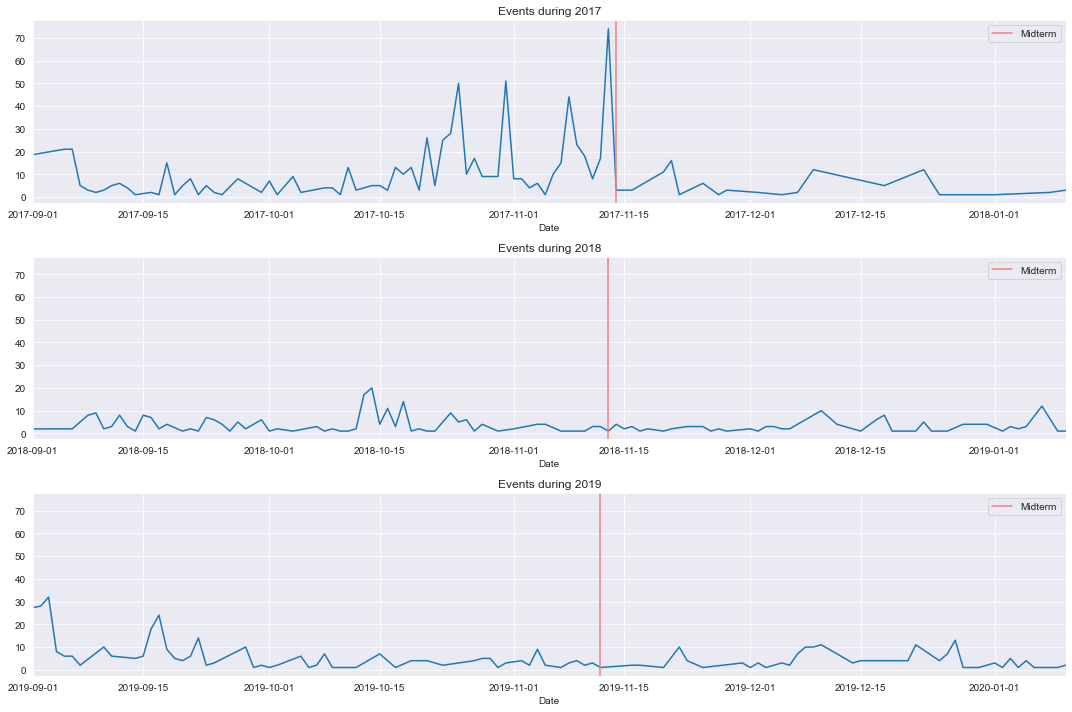

In [231]:
fig, axes = plt.subplots(3,1, figsize=((15,10)))
for i, year in enumerate([2017,2018,2019]):
    plot_events(forum_events, axes[i], year = year)
fig.tight_layout()

**Interpretation:** Comparing across the years we can notice a decrease of activity between 2017 and the following years. During 2017 we can see a distinct peak of activity right before the midterm, while there isn't any trend during 2018 and 2019.